<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

last updated: 2017-01-18 

CPython 2.7.10
IPython 5.1.0

numpy 1.12.0
scipy 0.18.1
pandas 0.19.0
sklearn 0.18
mlxtend 0.5.0


# Cosmic-ray composition feature selection
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Comparison of different sequential feature selections](#Comparison-of-different-sequential-feature-selections)
3. [Serialize feature selection algorithm](#Serialize-feature-selection-algorithm)

In [2]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [3]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import cPickle

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import composition as comp
import composition.analysis.plotting as plotting

# Plotting-related
sns.set_palette('muted')
sns.set_color_codes()
color_dict = {}
for i, composition in enumerate(['light', 'heavy', 'total']):
    color_dict[composition] = sns.color_palette('muted').as_hex()[i]
%matplotlib inline

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature selection

### Load simulation, format feature and target matrices

In [4]:
df_sim, cut_dict_sim = comp.load_dataframe(type_='sim', config='IT73', return_cut_dict=True)
selection_mask = np.array([True] * len(df_sim))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict_sim[key]

df_sim = df_sim[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train_sim, X_test_sim, y_train_sim, y_test_sim, le = comp.get_train_test_sets(
    df_sim, feature_list, comp_class=True)

print('number training events = ' + str(y_train_sim.shape[0]))
print('number testing events = ' + str(y_test_sim.shape[0]))

/home/jbourbeau/cr-composition/composition/load_dataframe.py:88: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))
/home/jbourbeau/cr-composition/composition/load_dataframe.py:89: RuntimeWarning: divide by zero encountered in log10
  df['log_NHits_1_30'] = np.nan_to_num(np.log10(df['NHits_1_30']))


training features = ['lap_log_energy', 'lap_cos_zenith', 'log_NChannels_1_30', 'nchannels_nhits_ratio', 'lap_likelihood', 'log_NHits_1_30', 'StationDensity', 'stationdensity_charge_ratio', 'nchannels_nhits_ratio', 'log_s50', 'log_s125', 'log_s500', 'lap_beta']
number training events = 145932
number testing events = 62543


### Load data, format feature and target matrices

In [5]:
df_data, cut_dict_data = comp.load_dataframe(type_='data', config='IC79', return_cut_dict=True)
selection_mask = np.array([True] * len(df_data))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict_data[key]

df_data = df_data[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
df_data = df_data.sample(frac=1).reset_index(drop=True)
X_test_data = df_data[feature_list].values

print('number testing events = ' + str(X_test_data.shape[0]))

training features = ['lap_log_energy', 'lap_cos_zenith', 'log_NChannels_1_30', 'nchannels_nhits_ratio', 'lap_likelihood', 'log_NHits_1_30', 'StationDensity', 'stationdensity_charge_ratio', 'nchannels_nhits_ratio', 'log_s50', 'log_s125', 'log_s500', 'lap_beta']
number testing events = 55562


# Comparison of different sequential feature selections
[ [back to top](#top) ]

In [6]:
pipeline = comp.get_pipeline('RF')
n_features_forward = X_train_sim.shape[1]
n_features_backward = 1

### SFS&mdash;sequential forward selection

In [8]:
sfs = SFS(pipeline, 
          k_features=n_features_forward, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=20)
sfs = sfs.fit(X_train_sim, y_train_sim)

Features: 13/13

### SFFS&mdash;sequential floating forward selection

In [9]:
sffs = SFS(pipeline, 
          k_features=n_features_forward, 
          forward=True, 
          floating=True, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=20)
sffs = sffs.fit(X_train_sim, y_train_sim)

Features: 13/13

### SBS&mdash;sequential backward selection

In [10]:
sbs = SFS(pipeline, 
          k_features=n_features_backward, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=20)
sbs = sbs.fit(X_train_sim, y_train_sim)

Features: 1/1

### SFBS&mdash;sequential floating backward selection

In [11]:
sfbs = SFS(pipeline, 
          k_features=n_features_backward, 
          forward=False, 
          floating=True, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=20)
sfbs = sfbs.fit(X_train_sim, y_train_sim)

Features: 1/1

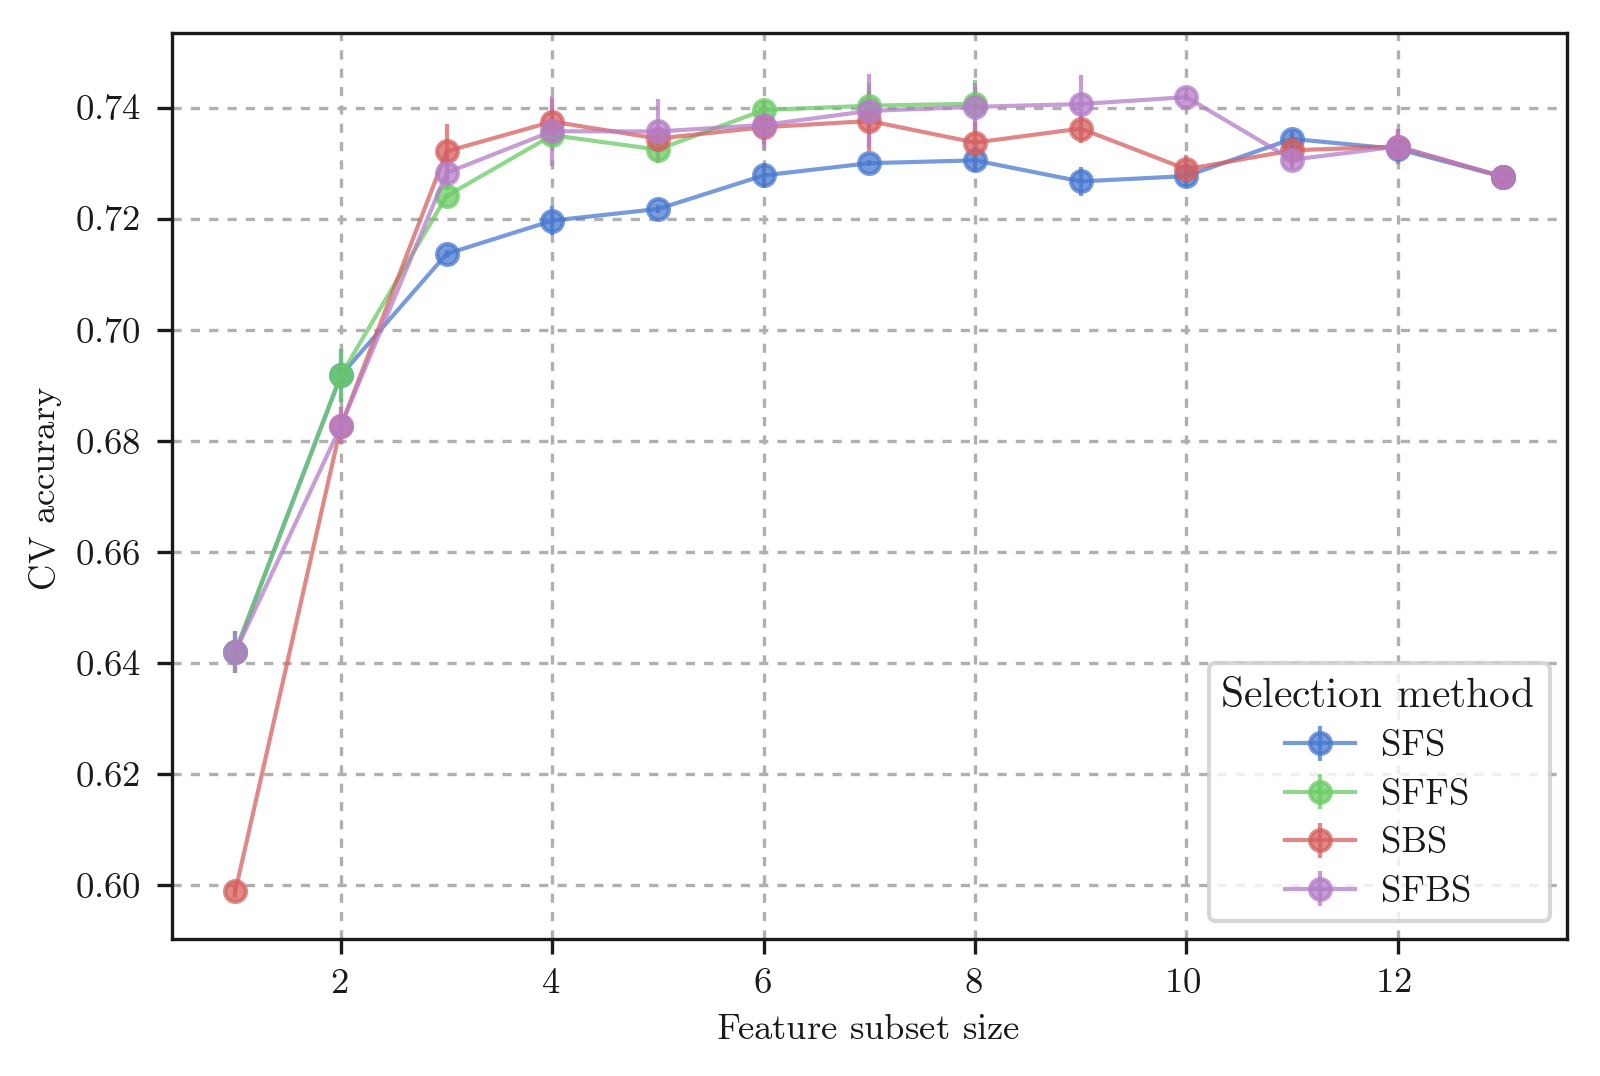

In [27]:
selector_list = [sfs, sffs, sbs, sfbs]
selector_label = {sfs:'SFS', sffs:'SFFS', sbs:'SBS', sfbs:'SFBS'}
fig, ax = plt.subplots()
for selector in selector_list:
    info = selector.get_metric_dict()
    scores = [info[size]['avg_score'] for size in info]
    errs = [info[size]['ci_bound'] for size in info]
    ax.errorbar(info.keys(), scores, yerr=errs,
                marker='.', linestyle='-', lw=1, alpha=0.75, 
                label=selector_label[selector])
plt.xlabel('Feature subset size')
plt.ylabel('CV accurary')
plt.grid(linestyle=':')
plt.legend(title='Selection method', loc='lower right')
plt.show()

In [21]:
for selector in selector_list:
    idx = selector.get_metric_dict()[8]['feature_idx']
    print(idx)
    print(selector_label[selector]+':')
    print(np.sort(feature_labels[list(idx)]))

(0, 2, 3, 4, 5, 9, 10, 12)
SFS:
['$\\log_{10}$(NChannels (top 50\\%))' '$\\log_{10}$(NHits (top 50\\%))'
 '$\\log_{10}(E_{\\mathrm{Lap}}/\\mathrm{GeV})$'
 '$\\log_{10}(S_{\\mathrm{125}})$' '$\\log_{10}(S_{\\mathrm{50}})$'
 '$r\\log_{10}(l)$' 'NChannels/NHits' 'lap beta']
(0, 1, 2, 3, 4, 5, 9, 10)
SFFS:
['$\\cos(\\theta_{\\mathrm{Lap}})$' '$\\log_{10}$(NChannels (top 50\\%))'
 '$\\log_{10}$(NHits (top 50\\%))'
 '$\\log_{10}(E_{\\mathrm{Lap}}/\\mathrm{GeV})$'
 '$\\log_{10}(S_{\\mathrm{125}})$' '$\\log_{10}(S_{\\mathrm{50}})$'
 '$r\\log_{10}(l)$' 'NChannels/NHits']
(0, 1, 2, 4, 8, 9, 10, 11)
SBS:
['$\\cos(\\theta_{\\mathrm{Lap}})$' '$\\log_{10}$(NChannels (top 50\\%))'
 '$\\log_{10}(E_{\\mathrm{Lap}}/\\mathrm{GeV})$'
 '$\\log_{10}(S_{\\mathrm{125}})$' '$\\log_{10}(S_{\\mathrm{500}})$'
 '$\\log_{10}(S_{\\mathrm{50}})$' '$r\\log_{10}(l)$' 'NChannels/NHits']
(0, 2, 4, 5, 8, 9, 10, 11)
SFBS:
['$\\log_{10}$(NChannels (top 50\\%))' '$\\log_{10}$(NHits (top 50\\%))'
 '$\\log_{10}(E_{\\mathrm{Lap

In [7]:
print('\nSequential Forward Selection:')
selected_features_str = 'Selected features:\n'
for idx in sfs.k_feature_idx_:
    selected_features_str += r'{}, '.format(feature_labels[idx])
print(selected_features_str)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection:
Selected features:
$\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$, $\log_{10}$(NChannels (top 50\%)), NChannels/NHits, $\log_{10}$(NHits (top 50\%)), $\log_{10}(S_{\mathrm{125}})$, lap beta, 
CV Score:
0.734951895403


# Serialize feature selection algorithm
[ [back to top](#top) ]

In [22]:
pipeline = comp.get_pipeline('RF')
n_features_forward = 8

### SFS&mdash;sequential forward selection

In [7]:
sfs = SFS(pipeline, 
          k_features=n_features_fotward, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=20)
sfs = sfs.fit(X_train_sim, y_train_sim)

Features: 8/8

Serialize `sfs` for later use (fitting procedure takes quite a while)

In [8]:
with open('feature-selection/sfs_nfeatures_{}.pkl'.format(n_features_forward), 'wb') as f_obj:
    cPickle.dump(sfs, f_obj, protocol=cPickle.HIGHEST_PROTOCOL)    

### SFFS&mdash;sequential floating forward selection

In [23]:
sffs = SFS(pipeline, 
          k_features=n_features_forward, 
          forward=True, 
          floating=True, 
          scoring='accuracy',
          print_progress=True,
          cv=3,
          n_jobs=20)
sffs = sffs.fit(X_train_sim, y_train_sim)

Features: 8/8

Serialize `sffs` for later use (fitting procedure takes quite a while)

In [24]:
with open('feature-selection/sffs_nfeatures_{}.pkl'.format(n_features_forward), 'wb') as f_obj:
    cPickle.dump(sffs, f_obj, protocol=cPickle.HIGHEST_PROTOCOL)    